In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from IPython.display import display
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

data = pd.read_csv('./df_input.csv', sep=';')

day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado",
}

busline_filter = 41
data_model = data[data.linha.isin([busline_filter])].copy()
display(data_model)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
2545,41,2020-10-20 04:00:00,57,1,8.878852e-01,0.460065,4,20,294,10,3
2546,41,2020-10-20 05:00:00,499,1,9.790841e-01,0.203456,5,20,294,10,3
2547,41,2020-10-20 06:00:00,938,1,9.976688e-01,-0.068242,6,20,294,10,3
2548,41,2020-10-20 07:00:00,965,1,9.422609e-01,-0.334880,7,20,294,10,3
2549,41,2020-10-20 08:00:00,558,1,8.169699e-01,-0.576680,8,20,294,10,3
...,...,...,...,...,...,...,...,...,...,...,...
1417949,41,2020-10-05 20:00:00,156,0,-7.308360e-01,0.682553,20,5,279,10,1
1417950,41,2020-10-05 21:00:00,137,0,-5.195840e-01,0.854419,21,5,279,10,1
1417951,41,2020-10-05 22:00:00,241,0,-2.697968e-01,0.962917,22,5,279,10,1
1417952,41,2020-10-05 23:00:00,81,0,-2.449294e-16,1.000000,23,5,279,10,1


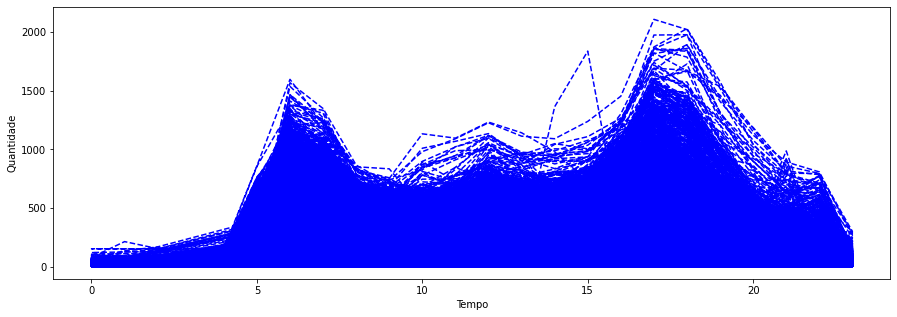

In [2]:
plt.figure(figsize=(15,5))
plt.xlabel('Tempo')
plt.ylabel('Quantidade')
plt.plot(data['hora'], data['validations_per_hour'], 'b--')
plt.show()

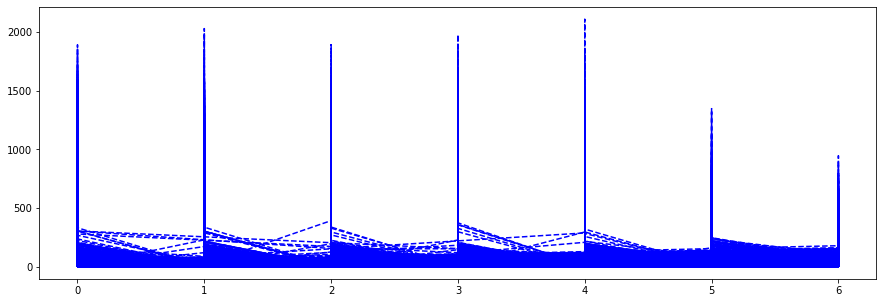

In [3]:
plt.figure(figsize=(15,5))
plt.plot(data['d_semana'], data['validations_per_hour'], 'b--')
plt.show()

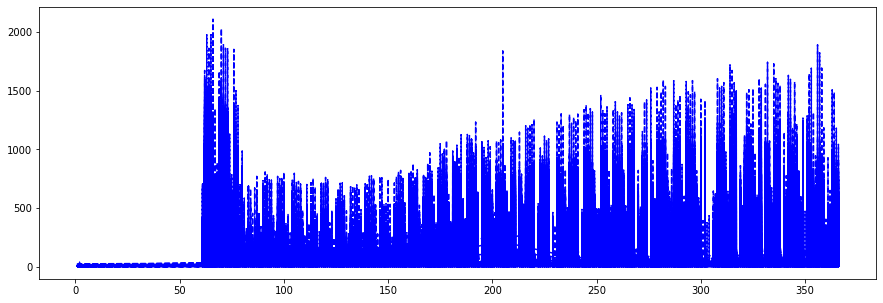

In [4]:
plt.figure(figsize=(15,5))
plt.plot(data['d_ano'], data['validations_per_hour'], 'b--')
plt.show()

In [5]:
time_steps = 24  #TAMANHO DA JANELA
test_size = 120  #HORIZONTE DE PREVISÃO
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))

train_size = int(len(data_model)-(test_size))
train, test = data_model.iloc[0:train_size], data_model.iloc[(train_size-time_steps):len(data_model)]
print(len(train), len(test))

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,0])#linha
        v = np.append(v,X.iloc[i + time_steps,3])#d_semana
        v = np.append(v,X.iloc[i + time_steps,10])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,11])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,12])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,13])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,14])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,15])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,16])#d_semanaonehotencoded
        v = np.append(v,X.iloc[i + time_steps,4])#hr_sin
        v = np.append(v,X.iloc[i + time_steps,5])#hr_cos
        v = np.append(v,X.iloc[i + time_steps,7])#d_mes -> provou ser melhor com a adicao deste componente
        v = np.append(v,X.iloc[i + time_steps,8])#d_ano
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['validations_per_hour'], time_steps)
X_test, y_test = create_dataset(test, test['validations_per_hour'], time_steps)


6052 144


In [6]:
display(data_model)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado
2545,41,2020-10-20 04:00:00,57,1,8.878852e-01,0.460065,4,20,294,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2546,41,2020-10-20 05:00:00,499,1,9.790841e-01,0.203456,5,20,294,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2547,41,2020-10-20 06:00:00,938,1,9.976688e-01,-0.068242,6,20,294,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2548,41,2020-10-20 07:00:00,965,1,9.422609e-01,-0.334880,7,20,294,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2549,41,2020-10-20 08:00:00,558,1,8.169699e-01,-0.576680,8,20,294,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417949,41,2020-10-05 20:00:00,156,0,-7.308360e-01,0.682553,20,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1417950,41,2020-10-05 21:00:00,137,0,-5.195840e-01,0.854419,21,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1417951,41,2020-10-05 22:00:00,241,0,-2.697968e-01,0.962917,22,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1417952,41,2020-10-05 23:00:00,81,0,-2.449294e-16,1.000000,23,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
display(X_train)

array([[ 41.        ,  41.        ,  41.        , ...,  -0.33487961,
          8.        , 282.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.57668032,
          8.        , 282.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.77571129,
          8.        , 282.        ],
       ...,
       [ 41.        ,  41.        ,  41.        , ...,  -0.33487961,
          9.        , 191.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.57668032,
          9.        , 191.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.77571129,
          9.        , 191.        ]])

In [8]:
display(X_test)

array([[ 41.        ,  41.        ,  41.        , ...,  -0.9172113 ,
          9.        , 191.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.99068595,
          9.        , 191.        ],
       [ 41.        ,  41.        ,  41.        , ...,  -0.99068595,
          9.        , 191.        ],
       ...,
       [ 41.        ,  41.        ,  41.        , ...,   0.96291729,
          5.        , 279.        ],
       [ 41.        ,  41.        ,  41.        , ...,   1.        ,
          5.        , 279.        ],
       [ 41.        ,  41.        ,  41.        , ...,   1.        ,
          6.        , 280.        ]])

120
     real   predito
0     345  389.9400
1     360  371.7500
2     399  415.7300
3     390  360.6000
4     436  414.5200
..    ...       ...
115   156  239.7900
116   137  180.9400
117   241  197.7900
118    81   36.7925
119    11   77.1635

[120 rows x 2 columns]
rmse= 72.16122299019639
mae= 47.95720059523809
mape= 0.4153553110969744
r2= 0.9279233702916175


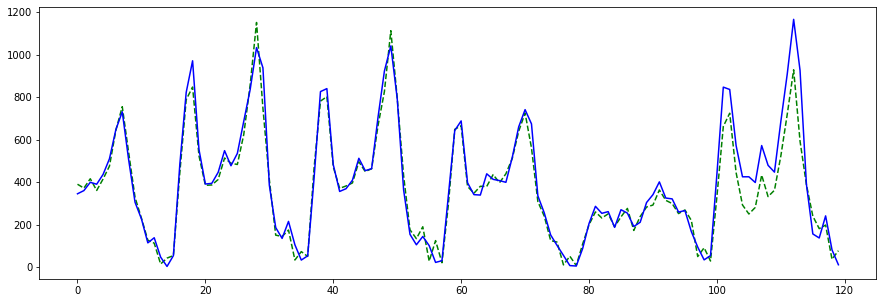

In [9]:
model = RandomForestRegressor(n_jobs=10).fit(X_train,y_train)
#model = LinearRegression.fit(X_train,y_train)
preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    y_pred = model.predict(np.array([base_teste[i]]))[0]

    preds.append(y_pred)
    
    for k in range(len(preds)):
        
        if i<len(base_teste):
            if k < time_steps:
                if(i<len(base_teste)-1):
                    base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]

print(len(preds))

dados_real = data_model.iloc[(train_size):len(data_model),2].to_numpy()

len(dados_real)

df_real_predito = pd.DataFrame({'real':dados_real,'predito':preds})

print(df_real_predito)
# X_train[0]

plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,30)
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('mape=',mean_absolute_percentage_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))

plt.show()